**Darwin's Bibliography**

Charles Darwin is widely regarded as one of the most influential figures in science. His most famous work, *On the Origin of Species* (1859), introduced the groundbreaking concept of natural selection. However, Darwin authored many other books covering a variety of subjects, including geology, botany, and aspects of his personal life.
In this notebook, we will explore how closely related his different works are based on their content.

To achieve this, we will build the foundation of a **content-based book recommendation system**. This system will identify which books are similar to one another by comparing the topics they discuss. Techniques used here are common in text-heavy fields such as legal, technical, or customer-support domains, where tasks like text classification and search engine optimization are essential.

Let’s begin by examining the collection of books we will use for our recommendation system.

In [1]:
# Import library
import glob

# The books files are contained in this folder
folder = "datasets/"

# List all the .txt files and sort them alphabetically
files = sorted(glob.glob("datasets/*.txt"))
files

['datasets\\Autobiography.txt',
 'datasets\\CoralReefs.txt',
 'datasets\\DescentofMan.txt',
 'datasets\\DifferentFormsofFlowers.txt',
 'datasets\\EffectsCrossSelfFertilization.txt',
 'datasets\\ExpressionofEmotionManAnimals.txt',
 'datasets\\FormationVegetableMould.txt',
 'datasets\\FoundationsOriginofSpecies.txt',
 'datasets\\GeologicalObservationsSouthAmerica.txt',
 'datasets\\InsectivorousPlants.txt',
 'datasets\\LifeandLettersVol1.txt',
 'datasets\\LifeandLettersVol2.txt',
 'datasets\\MonographCirripedia.txt',
 'datasets\\MonographCirripediaVol2.txt',
 'datasets\\MovementClimbingPlants.txt',
 'datasets\\OriginofSpecies.txt',
 'datasets\\PowerMovementPlants.txt',
 'datasets\\VariationPlantsAnimalsDomestication.txt',
 'datasets\\VolcanicIslands.txt',
 'datasets\\VoyageBeagle.txt']

**Load the contents of each book into Python**

First task is to import the text of all the books into Python and apply some basic preprocessing to prepare them for later analysis. This collection of texts is known as a *corpus*.  
We will also keep track of each book’s title for easy reference and display their individual lengths to get an initial sense of how much content each book contains.

In [3]:
# Import libraries
import re, os

# Initialize the object that will contain the texts and titles
txts = []
titles = []

for file in files:
    # Open each file
    with open(file, encoding='utf-8-sig') as f:    
        # Remove all non-alpha-numeric characters
        txt = re.sub(pattern=r"[\W_]+", repl=' ', string=f.read());
        # Store the texts and titles of the books in two separate lists
        txts.append(txt)
        titles.append(os.path.basename(file).replace(".txt",''))

# Print the length, in characters, of each book
[len(t) for t in txts]

[123231,
 496068,
 1776539,
 617088,
 913713,
 624232,
 335920,
 523021,
 797401,
 901406,
 1047518,
 1010643,
 767492,
 1660866,
 298319,
 916267,
 1093567,
 1043499,
 341447,
 1149574]

Find **"On the Origin of Species"**

For the next parts of this analysis, we will often check the results returned by our method for a given book. For consistency, we will refer to Darwin's most famous book: "On the Origin of Species." Let's find to which index this book is associated.

In [4]:
# Browse the list containing all the titles
for i in range(len(titles)):
    # Store the index if the title is "OriginofSpecies"
    if titles[i] == 'OriginofSpecies':
        ori = i

# Print the stored index
print(ori)

15


**Tokenize the corpus**

As a next step, we need to transform the corpus into a format that is easier to deal with for the downstream analyses. We will tokenize our corpus, i.e., transform each text into a list of the individual words (called tokens) it is made of. To check the output of our process, we will print the first 20 tokens of "On the Origin of Species".

In [5]:
# Define a list of stop words
stoplist = set('for a of the and to in to be which some is at that we i who whom show via may my our might as well'.split())

# Convert the text to lower case 
txts_lower_case = [txt.lower() for txt in txts]

# Transform the text into tokens 
txts_split = [txt.split(' ') for txt in txts_lower_case]

# Remove tokens which are part of the list of stop words
texts = [[token for token in tokens  if token not in stoplist]
         for tokens in txts_split]

# Print the first 20 tokens for the "On the Origin of Species" book
texts[ori][:20]

['',
 'on',
 'origin',
 'species',
 'but',
 'with',
 'regard',
 'material',
 'world',
 'can',
 'least',
 'go',
 'so',
 'far',
 'this',
 'can',
 'perceive',
 'events',
 'are',
 'brought']

**Stemming of the tokenized corpus**

If you have read *On the Origin of Species*, you will have noticed that Charles Darwin can use different words to refer to a similar concept. For example, the concept of selection can be described by words such as selection, selective, select or selects. This will dilute the weight given to this concept in the book and potentially bias the results of the analysis.

To solve this issue, it is a common practice to use a **stemming process**, which will group together the inflected forms of a word so they can be analysed as a single item: **the stem**. In our *On the Origin of Species* example, the words related to the concept of selection would be gathered under the *select* stem.

As we are analysing 20 full books, the stemming algorithm can take several minutes to run and, in order to make the process faster, we will directly load the final results from a pickle file and review the method used to generate it.

In [6]:
import pickle

reprocess = False

if reprocess:
    # Load the Porter stemming function from the nltk package
    from nltk.stem import PorterStemmer

    # Create an instance of a PorterStemmer object
    porter = PorterStemmer()

    # For each token of each text, we generated its stem 
    texts_stem = [[porter.stem(token) for token in text] for text in texts]

    # Save to pickle file
    pickle.dump(texts_stem, open("datasets/texts_stem.p", "wb"))
else:
    # Load the stemmed tokens list from the pregenerated pickle file
    texts_stem = pickle.load(open("datasets/texts_stem.p", "rb"))

# Print the 20 first stemmed tokens from the "On the Origin of Species" book
texts_stem[ori][:20]

['',
 'on',
 'origin',
 'speci',
 'but',
 'with',
 'regard',
 'materi',
 'world',
 'can',
 'least',
 'go',
 'so',
 'far',
 'thi',
 'can',
 'perceiv',
 'event',
 'are',
 'brought']

**Building a bag-of-words model**

Now that we have transformed the texts into stemmed tokens, we need to build models that will be useable by downstream algorithms.

First, we need to will create a universe of all words contained in our corpus of Charles Darwin's books, which we call *a dictionary*. Then, using the stemmed tokens and the dictionary, we will create **bag-of-words models** (BoW) of each of our texts. The BoW models will represent our books as a list of all uniques tokens they contain associated with their respective number of occurrences.

To better understand the structure of such a model, we will print the five first elements of one of the *"On the Origin of Species"* BoW model.

In [8]:
# Load the functions allowing to create and use dictionaries
from gensim import corpora

# Create a dictionary from the stemmed tokens
dictionary = corpora.Dictionary(texts_stem)

# Create a bag-of-words model for each book, using the previously generated dictionary
bows = [dictionary.doc2bow(text) for text in texts_stem]

# Print the first five elements of the On the Origin of species' BoW model
bows[ori][:5]

[(0, 2), (1, 11), (6, 51), (7, 1), (9, 2)]

**The most common words of a given book**

The results returned by the bag-of-words model is certainly easy to use for a computer but hard to interpret for a human. It is not straightforward to understand which stemmed tokens are present in a given book from Charles Darwin, and how many occurrences we can find.

In order to better understand how the model has been generated and visualize its content, we will transform it into a DataFrame and display the 10 most common stems for the book *"On the Origin of Species"*.

In [9]:
# Import pandas to create and manipulate DataFrames
import pandas as pd
# Convert the BoW model for "On the Origin of Species" into a DataFrame
df_bow_origin = pd.DataFrame(bows[ori])

# Add the column names to the DataFrame
df_bow_origin.columns = ['index', 'occurrences']

# Add a column containing the token corresponding to the dictionary index
toStem = lambda row: dictionary[row['index']]
df_bow_origin['token'] = df_bow_origin.apply(toStem, axis=1)


# Sort the DataFrame by descending number of occurrences and print the first 10 values
df_bow_origin.sort_values(by='occurrences', ascending=False, inplace=True)

df_bow_origin.head()

,index,occurrences,token
749,1169,2023,have
1120,1737,1558,on
1490,2289,1543,speci
893,1367,1480,it
240,394,1362,by


**Build a tf-idf model**

If it wasn't for the presence of the stem *"speci"*, we would have a hard time to guess this BoW model comes from the *On the Origin of Species book*. The most recurring words are, apart from few exceptions, very common and unlikely to carry any information peculiar to the given book. We need to use an additional step in order to determine which tokens are the most specific to a book.

To do so, we will use a **tf-idf model** (term frequency–inverse document frequency). This model defines the importance of each word depending on how frequent it is in this text and how infrequent it is in all the other documents. As a result, a high tf-idf score for a word will indicate that this word is specific to this text.

After computing those scores, we will print the 10 words most specific to the *"On the Origin of Species"* book (i.e., the 10 words with the highest tf-idf score).

In [10]:
# Load the gensim functions that will allow us to generate tf-idf models
from gensim.models import TfidfModel

# Generate the tf-idf model
model = TfidfModel(bows)

# Print the model for "On the Origin of Species"
model[bows[ori]]

[(9, np.float64(0.00020408683039616044)),
 (22, np.float64(0.0005723177174474165)),
 (24, np.float64(0.001714008058633542)),
 (28, np.float64(0.0006466337090765656)),
 (29, np.float64(0.0025710120879503125)),
 (32, np.float64(0.000857004029316771)),
 (36, np.float64(0.001016241827361025)),
 (37, np.float64(0.001016241827361025)),
 (52, np.float64(0.0008878482198272165)),
 (55, np.float64(0.00203248365472205)),
 (57, np.float64(0.0023786863377481767)),
 (58, np.float64(0.00010204341519808022)),
 (64, np.float64(0.0027579084706411254)),
 (65, np.float64(0.000510217075990401)),
 (67, np.float64(0.00020408683039616044)),
 (68, np.float64(0.0023786863377481767)),
 (69, np.float64(0.00203248365472205)),
 (76, np.float64(0.0013789542353205627)),
 (77, np.float64(0.00044392410991360827)),
 (79, np.float64(0.004177054182752995)),
 (81, np.float64(0.0020885270913764977)),
 (84, np.float64(0.008584765761711247)),
 (85, np.float64(0.000510217075990401)),
 (89, np.float64(0.0024490419647539255)),
 

**The results of the tf-idf model**

Once again, the format of those results is hard to interpret for a human. Therefore, we will transform it into a more readable version and display the 10 most specific words for the *"On the Origin of Species"* book.

In [11]:
# Convert the tf-idf model for "On the Origin of Species" into a DataFrame
df_tfidf = pd.DataFrame(model[bows[ori]])

# Name the columns of the DataFrame id and score
df_tfidf.columns = ['id', 'score']

# Add the tokens corresponding to the numerical indices for better readability
df_tfidf['token'] = [dictionary[id] for id in df_tfidf['id']]

# Sort the DataFrame by descending tf-idf score and print the first 10 rows.

df_tfidf.sort_values(by='score', ascending=False).head(10)

,id,score,token
880,2165,0.327823,select
3103,10109,0.204162,pigeon
128,370,0.197968,breed
2985,9396,0.167705,migrat
947,2326,0.148371,steril
285,753,0.146172,domest
504,1256,0.128433,hybrid
371,967,0.127694,fertil
3840,16047,0.124547,gärtner
3536,12730,0.121348,naturalis


**Compute distance between texts**

The results of the tf-idf algorithm now return stemmed tokens which are specific to each book. We can, for example, see that topics such as selection, breeding or domestication are defining *"On the Origin of Species"* (and yes, in this book, Charles Darwin talks quite a lot about pigeons too). Now that we have a model associating tokens to how specific they are to each book, we can measure how related to books are between each other.

To this purpose, we will use a measure of similarity called **cosine similarity** and we will visualize the results as a distance matrix, i.e., a matrix showing all pairwise distances between Darwin's books.

In [12]:
# Load the library allowing similarity computations
from gensim import similarities

# Compute the similarity matrix (pairwise distance between all texts)
sims = similarities.MatrixSimilarity(model[bows])

# Transform the resulting list into a dataframe
sim_df = pd.DataFrame(list(sims))

# Add the titles of the books as columns and index of the dataframe
sim_df.columns, sim_df.index = titles, titles

# Print the resulting matrix
sim_df

,Autobiography,CoralReefs,DescentofMan,DifferentFormsofFlowers,EffectsCrossSelfFertilization,ExpressionofEmotionManAnimals,FormationVegetableMould,FoundationsOriginofSpecies,GeologicalObservationsSouthAmerica,InsectivorousPlants,LifeandLettersVol1,LifeandLettersVol2,MonographCirripedia,MonographCirripediaVol2,MovementClimbingPlants,OriginofSpecies,PowerMovementPlants,VariationPlantsAnimalsDomestication,VolcanicIslands,VoyageBeagle
Autobiography,1.000000,0.049722,0.080789,0.066615,0.077006,0.089345,0.041182,0.058990,0.030679,0.014945,0.399534,0.220023,0.005854,0.008456,0.022999,0.101199,0.016059,0.048989,0.038630,0.184288
CoralReefs,0.049722,1.000000,0.009516,0.001980,0.001936,0.005062,0.029445,0.022066,0.060744,0.002284,0.031211,0.017772,0.006321,0.010497,0.001534,0.039200,0.002686,0.011383,0.057402,0.267414
DescentofMan,0.080789,0.009516,1.000000,0.072792,0.029997,0.148642,0.027106,0.135001,0.009628,0.009468,0.060040,0.080569,0.053426,0.042937,0.005157,0.267734,0.011267,0.228437,0.007885,0.123902
DifferentFormsofFlowers,0.066615,0.001980,0.072792,1.000000,0.391788,0.006545,0.010621,0.039993,0.002855,0.007487,0.016188,0.046692,0.009403,0.005451,0.008165,0.129152,0.018831,0.049405,0.002624,0.013213
EffectsCrossSelfFertilization,0.077006,0.001936,0.029997,0.391788,1.000000,0.006871,0.032270,0.040248,0.002247,0.006763,0.019609,0.046567,0.003218,0.002957,0.014939,0.146700,0.039520,0.054458,0.002183,0.017183
ExpressionofEmotionManAnimals,0.089345,0.005062,0.148642,0.006545,0.006871,1.000000,0.021066,0.047103,0.005246,0.011461,0.065391,0.049333,0.016802,0.029644,0.005942,0.063242,0.011234,0.082567,0.005595,0.099124
FormationVegetableMould,0.041182,0.029445,0.027106,0.010621,0.032270,0.021066,1.000000,0.021468,0.067712,0.035498,0.028357,0.023943,0.019864,0.023915,0.038823,0.049519,0.039911,0.032647,0.059299,0.098331
FoundationsOriginofSpecies,0.058990,0.022066,0.135001,0.039993,0.040248,0.047103,0.021468,1.000000,0.027300,0.005995,0.057749,0.054703,0.007650,0.010762,0.003971,0.322736,0.008712,0.196578,0.017528,0.089075
GeologicalObservationsSouthAmerica,0.030679,0.060744,0.009628,0.002855,0.002247,0.005246,0.067712,0.027300,1.000000,0.006844,0.028691,0.012241,0.009260,0.023486,0.002046,0.052878,0.003450,0.013737,0.372272,0.259514
InsectivorousPlants,0.014945,0.002284,0.009468,0.007487,0.006763,0.011461,0.035498,0.005995,0.006844,1.000001,0.006062,0.016549,0.019091,0.019657,0.249011,0.014982,0.022841,0.010321,0.008526,0.014758


**The book most similar to "On the Origin of Species"**

We now have a matrix containing all the similarity measures between any pair of books from Charles Darwin! We can now use this matrix to quickly extract the information we need, i.e., the distance between one book and one or several others.

As a first step, we will display which books are the most similar to *"On the Origin of Species,"* more specifically we will produce a bar chart showing all books ranked by how similar they are to Darwin's landmark work.

Text(0.5, 1.0, 'Books similar to the Origin of Species')

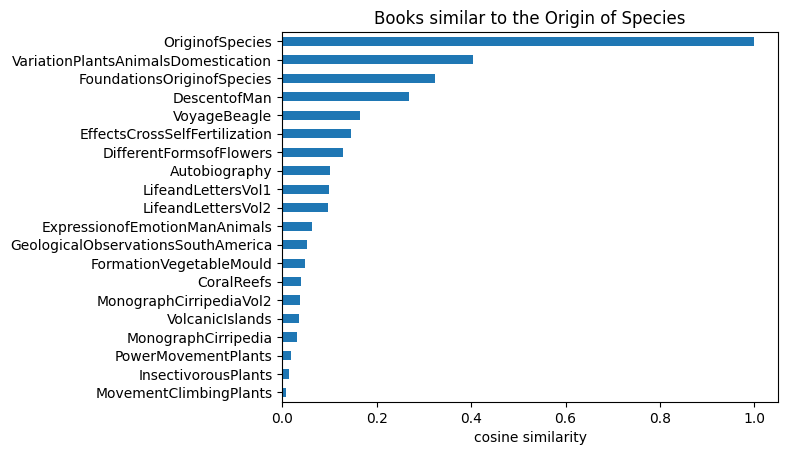

In [13]:
# This is needed to display plots in a notebook
%matplotlib inline

# Import libraries
import matplotlib.pyplot as plt

# Select the column corresponding to "On the Origin of Species" and 
v = sim_df['OriginofSpecies']

# Sort by ascending scores
v_sorted = v.sort_values(ascending=True)

# Plot this data has a horizontal bar plot
v_sorted.plot.barh()

# Modify the axes labels and plot title for a better readability
plt.xlabel('cosine similarity')
plt.title('Books similar to the Origin of Species')

**Which books have similar content?**

This turns out to be extremely useful if we want to determine a given book's most similar work. For example, we have just seen that if you enjoyed *"On the Origin of Species,"* you can read books discussing similar concepts such as *"The Variation of Animals and Plants under Domestication"* or *"The Descent of Man, and Selection in Relation to Sex."* If you are familiar with Darwin's work, these suggestions will likely seem natural to you. Indeed, *On the Origin of Species* has a whole chapter about domestication and *The Descent of Man, and Selection in Relation to Sex* applies the theory of natural selection to human evolution. Hence, the results make sense.

However, we now want to have a better understanding of the big picture and see how Darwin's books are generally related to each other (in terms of topics discussed). To this purpose, we will represent the whole similarity matrix as a dendrogram, which is a standard tool to display such data. *This last approach will display all the information about book similarities at once.* For example, we can find a book's closest relative but, also, we can visualize which groups of books have similar topics (e.g., the cluster about Charles Darwin personal life with his autobiography and letters). If you are familiar with Darwin's bibliography, the results should not surprise you too much, which indicates the method gives good results. Otherwise, next time you read one of the author's book, you will know which other books to read next in order to learn more about the topics it addressed.

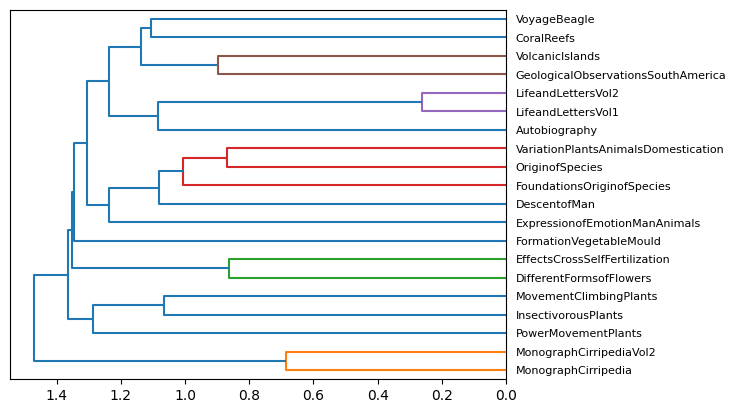

In [14]:
# Import libraries
from scipy.cluster import hierarchy

# Compute the clusters from the similarity matrix,
# using the Ward variance minimization algorithm
Z =hierarchy.linkage(sims)

# Display this result as a horizontal dendrogram
_ = hierarchy.dendrogram(Z, leaf_font_size=8, labels=sim_df.index, orientation='left')